# Uploading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs

#### File nomenclature
import _epo.fif files
    
    format: "g"+ group_number + player_type + subject +'_epo.fif'
    player_type: ["solo", "dual"]
    subject: [1, 2]

In [2]:
url = './data/'

print("\n========= epoch_1 ==========")

# epoch_1
file_name_1 = 'g1dual1_epo.fif' # eg. 'g1dual1_epo.fif'
epoch_1 = read_epochs(url + file_name_1)
print("\n========= epoch_2 ==========")

# epoch_2
file_name_2 = 'g1solo1_epo.fif' # eg. 'g1dual2_epo.fif'
epoch_2 = read_epochs(url + file_name_2)


========= epoch_1 ==========
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated

========= epoch_2 ==========
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [3]:
X_train = epoch_1.get_data()
y_train = np.array(epoch_1.events[:, -1], dtype = 'float32')

print(X_train.shape)
print(y_train.shape)

(636, 32, 410)
(636,)


In [4]:
X_val = epoch_2.get_data()
y_val = np.array(epoch_2.events[:, -1], dtype = 'float32')

print(X_val.shape)
print(y_val.shape)

(240, 32, 410)
(240,)


## Separating Regions
Region channels
- 0-7 --> F
- 7-11, 12-15 --> C
- 16-25 --> P
- 25 -- 32> 0
- 11-12, 15-16 --> T

In [5]:
X_train_F = X_train[:, 0:7, :]
X_train_P = X_train[:, 16:25, :]
X_train_O = X_train[:, 25:32, :]
X_train_C1 = X_train[:, 7:11, :]
X_train_C2 = X_train[:, 12:15, :]
X_train_C = np.concatenate((X_train_C1, X_train_C2), axis=1)
X_train_T1 = X_train[:, 11:12, :]
X_train_T2 = X_train[:, 15:16, :]
X_train_T = np.concatenate((X_train_T1, X_train_T2), axis=1)
print("F",X_train_F.shape)
print("C", X_train_C.shape)
print("P", X_train_P.shape)
print("O", X_train_O.shape)
print("T", X_train_T.shape)


F (636, 7, 410)
C (636, 7, 410)
P (636, 9, 410)
O (636, 7, 410)
T (636, 2, 410)


In [6]:
X_val_F = X_val[:, 0:7, :]
X_val_P = X_val[:, 16:25, :]
X_val_O = X_val[:, 25:32, :]
X_val_C1 = X_val[:, 7:11, :]
X_val_C2 = X_val[:, 12:15, :]
X_val_C = np.concatenate((X_val_C1, X_val_C2), axis=1)
X_val_T1 = X_val[:, 11:12, :]
X_val_T2 = X_val[:, 15:16, :]
X_val_T = np.concatenate((X_val_T1, X_val_T2), axis=1)

print("F", X_val_F.shape)
print("C", X_val_C.shape)
print("P", X_val_P.shape)
print("O", X_val_O.shape)
print("T", X_val_T.shape)

F (240, 7, 410)
C (240, 7, 410)
P (240, 9, 410)
O (240, 7, 410)
T (240, 2, 410)


#### Creating Tensors

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
X_F = torch.Tensor(X_train_F)
X_C = torch.Tensor(X_train_C)
X_P = torch.Tensor(X_train_P)
X_O = torch.Tensor(X_train_O)
X_T = torch.Tensor(X_train_T)
y = torch.Tensor(y_train)
y = y - 1
y = y.unsqueeze(1)
print("X shape")
print("F :",X_F.size())
print("C :",X_C.size())
print("P :",X_P.size())
print("O :",X_O.size())
print("T :",X_T.size())
print("y shape:",y.size())

print('\n')

X_val_F = torch.Tensor(X_val_F)
X_val_C = torch.Tensor(X_val_C)
X_val_P = torch.Tensor(X_val_P)
X_val_O = torch.Tensor(X_val_O)
X_val_T = torch.Tensor(X_val_T)
y_val = torch.Tensor(y_val)
y_val = y_val - 1
y_val = y_val.unsqueeze(1)
print("X_val shape")
print("F :",X_val_F.size())
print("C :",X_val_C.size())
print("P :",X_val_P.size())
print("O :",X_val_O.size())
print("T :",X_val_T.size())
print("y_val shape:",y_val.size())

X shape
F : torch.Size([636, 7, 410])
C : torch.Size([636, 7, 410])
P : torch.Size([636, 9, 410])
O : torch.Size([636, 7, 410])
T : torch.Size([636, 2, 410])
y shape: torch.Size([636, 1])


X_val shape
F : torch.Size([240, 7, 410])
C : torch.Size([240, 7, 410])
P : torch.Size([240, 9, 410])
O : torch.Size([240, 7, 410])
T : torch.Size([240, 2, 410])
y_val shape: torch.Size([240, 1])


In [10]:
train_ds_F = TensorDataset(X_F, y)
valid_ds_F = TensorDataset(X_val_F, y_val)

train_ds_C = TensorDataset(X_C, y)
valid_ds_C = TensorDataset(X_val_C, y_val)

train_ds_P = TensorDataset(X_P, y)
valid_ds_P = TensorDataset(X_val_P, y_val)

train_ds_O = TensorDataset(X_O, y)
valid_ds_O = TensorDataset(X_val_O, y_val)

train_ds_T = TensorDataset(X_T, y)
valid_ds_T = TensorDataset(X_val_T, y_val)

# train_size = int(X.size()[0] * 0.8)
# valid_size = X.size()[0] - train_size

# train_set, valid_set = torch.utils.data.random_split(train_ds, [train_size, valid_size])

BATCH_SIZE= 64

train_iterator_F = torch.utils.data.DataLoader(dataset=train_ds_F, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_F = torch.utils.data.DataLoader(dataset=valid_ds_F, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_C = torch.utils.data.DataLoader(dataset=train_ds_C, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_C = torch.utils.data.DataLoader(dataset=valid_ds_C, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_P = torch.utils.data.DataLoader(dataset=train_ds_P, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_P = torch.utils.data.DataLoader(dataset=valid_ds_P, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_O = torch.utils.data.DataLoader(dataset=train_ds_O, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_O = torch.utils.data.DataLoader(dataset=valid_ds_O, batch_size=BATCH_SIZE, shuffle=False)

train_iterator_T = torch.utils.data.DataLoader(dataset=train_ds_T, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_T = torch.utils.data.DataLoader(dataset=valid_ds_T, batch_size=BATCH_SIZE, shuffle=False)

#### Model

In [11]:
class CNN(nn.Module):
    def __init__(self,input_dim,hidden_dim, num_layers, num_classes, bidirectional, dropout):
        super(CNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        #Layer 0
        self.layer0 = nn.BatchNorm1d(input_dim)
        
        #Layer 1
        self.layer1 = nn.Sequential(nn.BatchNorm1d(input_dim),
                    nn.Conv1d(in_channels= input_dim, out_channels= 16, kernel_size = 1, stride=1),
                    nn.Tanh())
        
        #Layer2
        self.layer2 = nn.Sequential(nn.BatchNorm1d(16),
                    nn.Conv1d(in_channels= 16, out_channels= 16 , kernel_size = 20, stride = 20),
                    nn.Tanh())
        
        # layer 3, lstm
        self.lstm = nn.LSTM(16, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        # layer 4, fc
        self.fc1 = nn.Linear(hidden_dim * num_layers, 1) #hidden_dim * num_layers
       # self.fc2 = nn.Linear(128, 128)
        #self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout)
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        
        
        
#         #Layer3
#         self.fc1 = nn.Sequential(
#                     nn.Flatten(),
#                     nn.Linear( 16 * round(self.input_samples/ 20), 128),
#                     nn.Tanh(),
#                     nn.Dropout(p=0.8))
#         #Layer4
#         self.fc2 = nn.Sequential(
#                     nn.Linear(128 , 128),
#                     nn.Tanh(),
#                     nn.Dropout(p=0.8))
        
#         #Layer5
#         self.fc3 = nn.Sequential(nn.Linear(128 , num_classes),nn.Sigmoid())
    
    
    def forward(self, x):
        
#         x = x.unsqueeze(0)
#         x = x.permute(1, 3, 0, 2)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        
        out,_ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.dropout(out)
       # out = self.fc2(out)
      #  out = self.dropout(out)
        #out = self.fc3(out)
       # out = self.dropout(out)
        out = self.sigmoid(out)
        return out

## Region F

In [12]:
learning_rate=0.001
epoches = 50
input_dim = X_F.shape[1]
hidden_dim = 128
num_layers = 2
num_classes =2
bidirectional = True
dropout = 0.2

model_F = CNN(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_F.parameters(), lr=learning_rate)
print(model_F)

CNN(
  (layer0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(7, 16, kernel_size=(1,), stride=(1,))
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): Tanh()
  )
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


In [13]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
       # print("predictions",predictions)
        #print("labels", labels)
        predicted = predictions.round()
#         print("train predicted",predicted)
#         _, predicted = torch.max(predictions.data, 1) 
        #returns max value, indices
#         predicted = predicted.unsqueeze(1)
        total += labels.size(0)  #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
        correct += (predicted == labels).sum().item()
#         print("label",labels.size())
#         print("predicted", predicted.size())
#         print("correct", correct)
#         print("total", total)
#         print("acc", correct/ total)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
#             print("test predicted",predicted)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [14]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Train, validation

In [15]:
N_EPOCHS = 12

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_F, train_iterator_F, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_F, valid_iterator_F, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.612 | Train Acc: 83.33%
	 Val. Loss: 0.457 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 83.33%
	 Val. Loss: 0.456 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.513 | Train Acc: 83.33%
	 Val. Loss: 0.471 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.493 | Train Acc: 83.33%
	 Val. Loss: 0.451 |  Val. Acc: 83.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.496 | Train Acc: 83.33%
	 Val. Loss: 0.443 |  Val. Acc: 83.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.511 | Train Acc: 83.33%
	 Val. Loss: 0.448 |  Val. Acc: 83.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.502 | Train Acc: 83.33%
	 Val. Loss: 0.443 |  Val. Acc: 83.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 83.33%
	 Val. Loss: 0.436 |  Val. Acc: 83.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.494 | Train Acc: 83.33%
	 Val. Loss: 0.437 |  Val. Acc: 83.46%
Epoch: 10 | Epoch Time: 0m 0

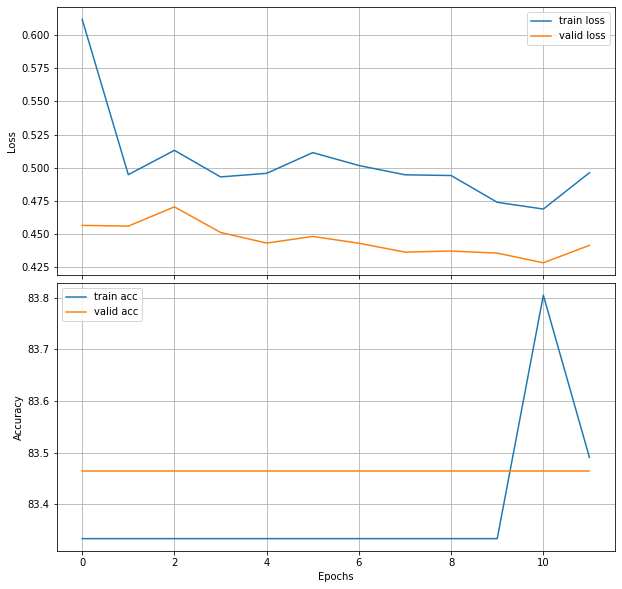

In [16]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## Region C

In [17]:
learning_rate=0.001
epoches = 50
input_dim = X_C.shape[1]
hidden_dim = 128
num_layers = 2
num_classes =2
bidirectional = True
dropout = 0.2

model_C = CNN(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)
print(model_C)

CNN(
  (layer0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(7, 16, kernel_size=(1,), stride=(1,))
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): Tanh()
  )
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


In [18]:
N_EPOCHS = 12

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_C, train_iterator_C, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_C, valid_iterator_C, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Acc: 83.33%
	 Val. Loss: 0.452 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.527 | Train Acc: 83.33%
	 Val. Loss: 0.470 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.507 | Train Acc: 83.33%
	 Val. Loss: 0.460 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.501 | Train Acc: 83.33%
	 Val. Loss: 0.463 |  Val. Acc: 83.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.501 | Train Acc: 83.18%
	 Val. Loss: 0.572 |  Val. Acc: 82.41%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.486 | Train Acc: 83.33%
	 Val. Loss: 0.450 |  Val. Acc: 83.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.505 | Train Acc: 83.33%
	 Val. Loss: 0.450 |  Val. Acc: 83.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.482 | Train Acc: 83.33%
	 Val. Loss: 0.450 |  Val. Acc: 83.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.484 | Train Acc: 83.33%
	 Val. Loss: 0.462 |  Val. Acc: 83.46%
Epoch: 10 | Epoch Time: 0m 0

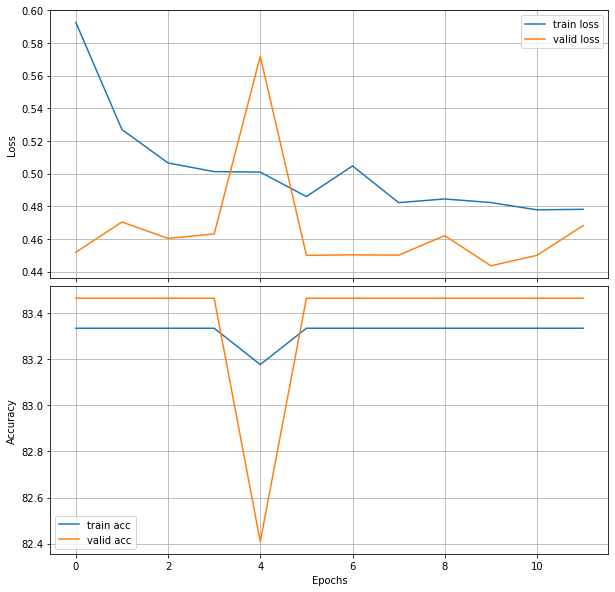

In [19]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## Region P

In [20]:
learning_rate=0.001
epoches = 50
input_dim = X_P.shape[1]
hidden_dim = 128
num_layers = 2
num_classes =2
bidirectional = True
dropout = 0.2

model_P = CNN(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_P.parameters(), lr=learning_rate)
print(model_P)

CNN(
  (layer0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(9, 16, kernel_size=(1,), stride=(1,))
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): Tanh()
  )
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


In [21]:
N_EPOCHS = 12

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_P, train_iterator_P, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_P, valid_iterator_P, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.618 | Train Acc: 83.33%
	 Val. Loss: 0.478 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.521 | Train Acc: 83.33%
	 Val. Loss: 0.465 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.480 | Train Acc: 83.33%
	 Val. Loss: 0.464 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.483 | Train Acc: 83.33%
	 Val. Loss: 0.458 |  Val. Acc: 83.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.466 | Train Acc: 83.33%
	 Val. Loss: 0.582 |  Val. Acc: 83.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.437 | Train Acc: 83.65%
	 Val. Loss: 0.526 |  Val. Acc: 81.16%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.433 | Train Acc: 85.06%
	 Val. Loss: 0.382 |  Val. Acc: 82.01%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.403 | Train Acc: 85.85%
	 Val. Loss: 0.352 |  Val. Acc: 84.01%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.368 | Train Acc: 86.64%
	 Val. Loss: 0.391 |  Val. Acc: 85.17%
Epoch: 10 | Epoch Time: 0m 0

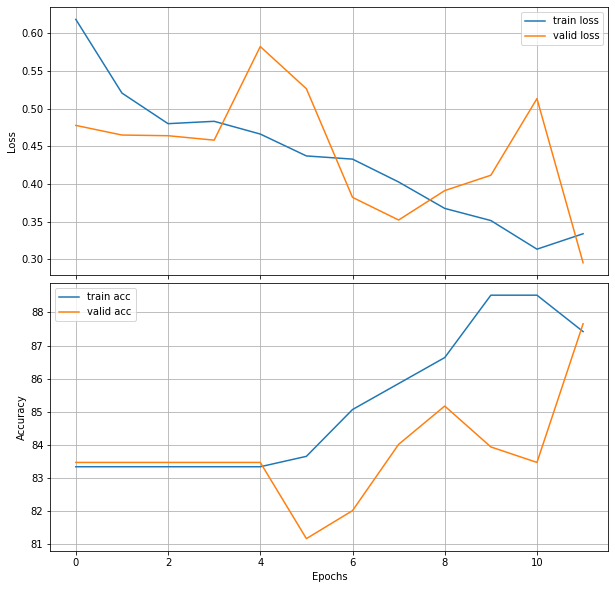

In [22]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## Region O

In [23]:
learning_rate=0.001
epoches = 50
input_dim = X_O.shape[1]
hidden_dim = 128
num_layers = 2
num_classes =2
bidirectional = True
dropout = 0.2

model_O = CNN(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_O.parameters(), lr=learning_rate)
print(model_O)

CNN(
  (layer0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(7, 16, kernel_size=(1,), stride=(1,))
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): Tanh()
  )
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


In [24]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_O, train_iterator_O, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_O, valid_iterator_O, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.612 | Train Acc: 83.33%
	 Val. Loss: 0.456 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.526 | Train Acc: 83.33%
	 Val. Loss: 0.470 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.486 | Train Acc: 83.33%
	 Val. Loss: 0.455 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.481 | Train Acc: 83.33%
	 Val. Loss: 0.463 |  Val. Acc: 83.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.488 | Train Acc: 83.33%
	 Val. Loss: 0.466 |  Val. Acc: 83.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.480 | Train Acc: 83.33%
	 Val. Loss: 0.620 |  Val. Acc: 83.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.492 | Train Acc: 83.33%
	 Val. Loss: 0.499 |  Val. Acc: 83.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.474 | Train Acc: 83.33%
	 Val. Loss: 0.473 |  Val. Acc: 83.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.474 | Train Acc: 83.49%
	 Val. Loss: 0.433 |  Val. Acc: 83.46%
Epoch: 10 | Epoch Time: 0m 0

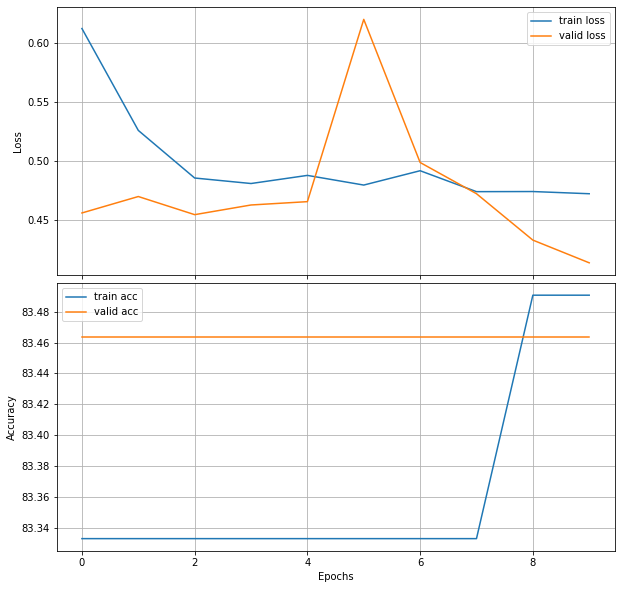

In [25]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## Region T

In [26]:
learning_rate=0.001
epoches = 50
input_dim = X_T.shape[1]
hidden_dim = 128
num_layers = 2
num_classes =2
bidirectional = True
dropout = 0.2

model_T = CNN(input_dim, hidden_dim, num_layers, num_classes, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_T.parameters(), lr=learning_rate)
print(model_T)

CNN(
  (layer0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(2, 16, kernel_size=(1,), stride=(1,))
    (2): Tanh()
  )
  (layer2): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(16, 16, kernel_size=(20,), stride=(20,))
    (2): Tanh()
  )
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)


In [27]:
N_EPOCHS = 12

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model_T, train_iterator_T, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model_T, valid_iterator_T, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Acc: 83.33%
	 Val. Loss: 0.451 |  Val. Acc: 83.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.524 | Train Acc: 83.33%
	 Val. Loss: 0.474 |  Val. Acc: 83.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.494 | Train Acc: 83.33%
	 Val. Loss: 0.457 |  Val. Acc: 83.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.519 | Train Acc: 83.33%
	 Val. Loss: 0.454 |  Val. Acc: 83.46%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.494 | Train Acc: 83.33%
	 Val. Loss: 0.462 |  Val. Acc: 83.46%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.516 | Train Acc: 83.33%
	 Val. Loss: 0.464 |  Val. Acc: 83.46%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.495 | Train Acc: 83.33%
	 Val. Loss: 0.445 |  Val. Acc: 83.46%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.501 | Train Acc: 83.33%
	 Val. Loss: 0.445 |  Val. Acc: 83.46%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.500 | Train Acc: 83.33%
	 Val. Loss: 0.445 |  Val. Acc: 83.46%
Epoch: 10 | Epoch Time: 0m 0

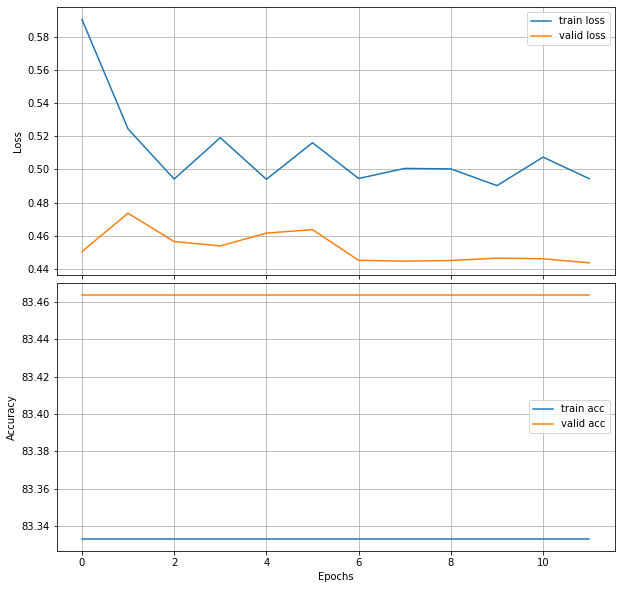

In [28]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()